In [23]:
%matplotlib inline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(1)

In [24]:
#read FATS for OGLE3 light curves 
df_ogle_dr3 = pd.read_csv('/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/OGLE_DR3_2024.csv')

In [25]:
# Remove the '.dat' extension
df_ogle_dr3['cleaned_ID'] = df_ogle_dr3['ID'].str.replace('.dat', '')

# Split the column into four new columns
df_ogle_dr3[['survey', 'field', 'star_type', 'id_number']] = df_ogle_dr3['cleaned_ID'].str.split('-', expand=True)

# remove columns which wont be used as features  
df_ogle_dr3.drop(axis='columns', columns=['cleaned_ID', 'survey', 'id_number', 'field', 'ID'], inplace=True)

# select star types that will be included in our model
df_ogle_dr3 = df_ogle_dr3[df_ogle_dr3.star_type.isin(['RRLYR', 'CEP', 'ECL', 'LPV', 'DSCT'])]

# check star types
df_ogle_dr3.star_type.unique()


array(['ECL', 'RRLYR', 'CEP', 'LPV', 'DSCT'], dtype=object)

In [26]:
# copy the df to be used to train a classifier
df_to_train = df_ogle_dr3.copy()

# define the label that will be provided to the classifier
label = df_to_train['star_type']

# delete the label from the trainig set
del df_to_train['star_type']

# create a ranfom forest classifier
clf = RandomForestClassifier(max_depth=5, random_state=0)

# fit the classifier
clf.fit(df_to_train, label)

# obtain soft predictions for each star
soft_prediction =  clf.predict_proba(df_to_train)

soft_prediction

array([[1.11622034e-01, 1.62241183e-02, 6.78115320e-01, 1.06675257e-01,
        8.73632708e-02],
       [6.22223608e-02, 1.09420619e-02, 3.90469185e-02, 2.48543473e-02,
        8.62934311e-01],
       [9.95719690e-02, 1.26955221e-02, 4.36599495e-02, 1.16573641e-02,
        8.32415195e-01],
       ...,
       [1.55790598e-03, 1.63659553e-04, 7.41433650e-03, 9.89237047e-01,
        1.62705104e-03],
       [7.10075282e-03, 2.69654003e-04, 8.08464822e-03, 9.77811173e-01,
        6.73377201e-03],
       [1.03579634e-03, 2.95980725e-04, 1.53264005e-02, 9.82212776e-01,
        1.12904605e-03]])

In [27]:
# prediction example
print(soft_prediction[0])
print(clf.classes_)

[0.11162203 0.01622412 0.67811532 0.10667526 0.08736327]
['CEP' 'DSCT' 'ECL' 'LPV' 'RRLYR']


In [28]:
soft_prediction.shape

(419257, 5)

In [29]:
# prediction example
print(soft_prediction[1])
print(clf.classes_)

[0.06222236 0.01094206 0.03904692 0.02485435 0.86293431]
['CEP' 'DSCT' 'ECL' 'LPV' 'RRLYR']


In [30]:
# Assign the soft predictions to the training set
df_to_train[['soft_pred_cep', 'soft_pred_dsct', 'soft_pred_ecl', 'soft_pred_lpv', 'soft_pred_rrlyr']] = soft_prediction

# Create the squared columns using vectorized operations
soft_pred_columns = ['soft_pred_cep', 'soft_pred_dsct', 'soft_pred_ecl', 'soft_pred_lpv', 'soft_pred_rrlyr']
df_to_train[[col + '_2' for col in soft_pred_columns]] = df_to_train[soft_pred_columns] ** 2

# Calculate the 'h' column, which quantifies the classification hardness for each star.
# This metric is derived from the multi-class extension of the Gini impurity index.
# The 'h' value represents the level of uncertainty or difficulty in classifying each star.
# Values close to 0 indicate that the star is likely to belong to a single class with high confidence,
# while higher values suggest more uncertainty, with the star having non-negligible probabilities across multiple classes.
df_to_train['h'] = 1 - df_to_train[[col + '_2' for col in soft_pred_columns]].sum(axis=1)


In [31]:
# Set the bias factor (T controls the strength of the bias)
T = 1

# Calculate a bias factor based on the hardness score 'h'
# The hardness score 'h' determines how challenging it is to classify each star.
# Multiplying 'h' by T scales the bias factor accordingly.
factor = T * df_to_train['h']

# Compute the exponential of the negative bias factor
# This step creates a probability-like value 'e' that decreases as the hardness 'h' increases.
# Stars that are harder to classify (higher 'h') will have lower 'e' values, leading to a higher chance of being excluded from the training set.
df_to_train['e'] = np.exp(-factor)

# Generate a random uniform value 'u' for each star between 0 and 1
# This random value is used to introduce stochasticity into the selection process.
df_to_train['u'] = np.random.uniform(0, 1, df_to_train.shape[0])

# Assign label, field, and ID columns from another DataFrame to df_to_train
# This step is for associating metadata with each star in the dataset.
df_to_train[['label', 'field', 'ID']] = pd.DataFrame({
    'label': label,
    'field': df_ogle_dr3['field'].values,
    'ID': df_ogle_dr3['ID'].values
})

# Select stars for the test set where 'e' is less than or equal to 'u'
# Stars with higher hardness (low 'e') are more likely to end up in the test set,
# meaning the test set will contain more challenging examples, thus inducing bias.
data_test = df_to_train[df_to_train['e'] <= df_to_train['u']]
print(data_test.shape)
print(data_test.label.value_counts())

# Select stars for the training set where 'e' is greater than 'u'
# Stars that are easier to classify (high 'e') are more likely to remain in the training set,
# leading to a biased training set that consists of easier-to-classify examples.
data_train = df_to_train[df_to_train['e'] > df_to_train['u']]
print(data_train.shape)
print(data_train.label.value_counts())


KeyError: 'field'

<AxesSubplot:>

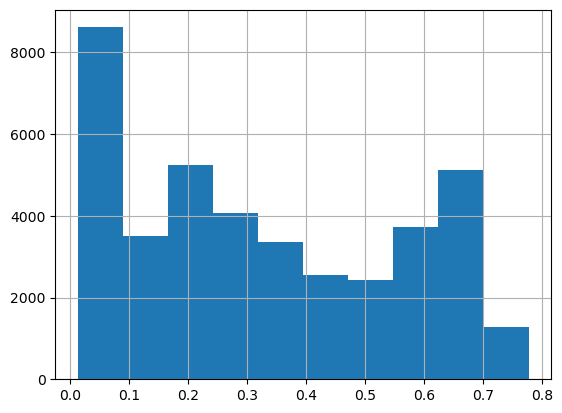

In [ ]:
data_test.h.hist()

<AxesSubplot:>

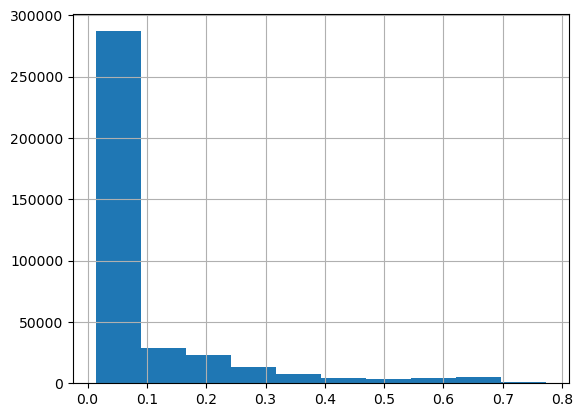

In [ ]:
data_train.h.hist()

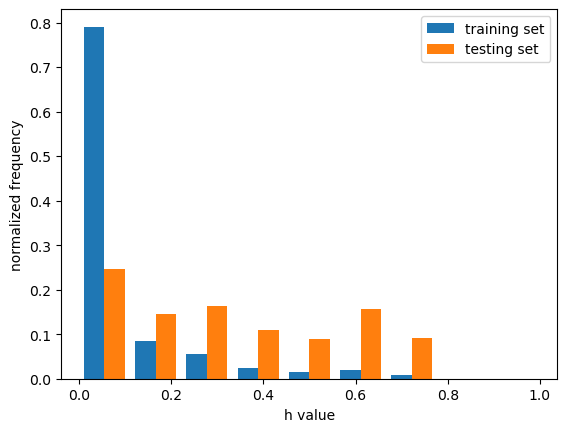

In [ ]:
#sets up the axis and gets histogram data
x = data_train.h
y = data_test.h
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])
bins = np.linspace(0, 1, 10)
plt.hist([x, y], bins, weights=[x_w, y_w], label=['training set', 'testing set'])
plt.legend(loc='upper right')
plt.xlabel('h value')
plt.ylabel('normalized frequency')
plt.show()

In [ ]:
data_train.to_csv('train_OGLEDR3_T1.csv')

In [ ]:
data_test.to_csv('test_OGLEDR3_T1.csv')